Train X shape: (2084, 28, 28, 1)
Test  X shape: (522, 28, 28, 1)
Train Y shape: (2084,)
Test  Y shape: (522,)
Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.1442 - loss: 2.2849 - val_accuracy: 0.2280 - val_loss: 2.1287
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2960 - loss: 2.0034 - val_accuracy: 0.3333 - val_loss: 1.9198
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3968 - loss: 1.7108 - val_accuracy: 0.3966 - val_loss: 1.7281
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4787 - loss: 1.4942 - val_accuracy: 0.4406 - val_loss: 1.5773
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5714 - loss: 1.2691 - val_accuracy: 0.4540 - val_loss: 1.5938
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6002 - loss: 1.1623 - val_accuracy: 0.5230 - val_loss: 1.4625
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6777 - loss: 0.9636 - val_accuracy: 0.5172 - val_loss: 1.4905
Epoch 8

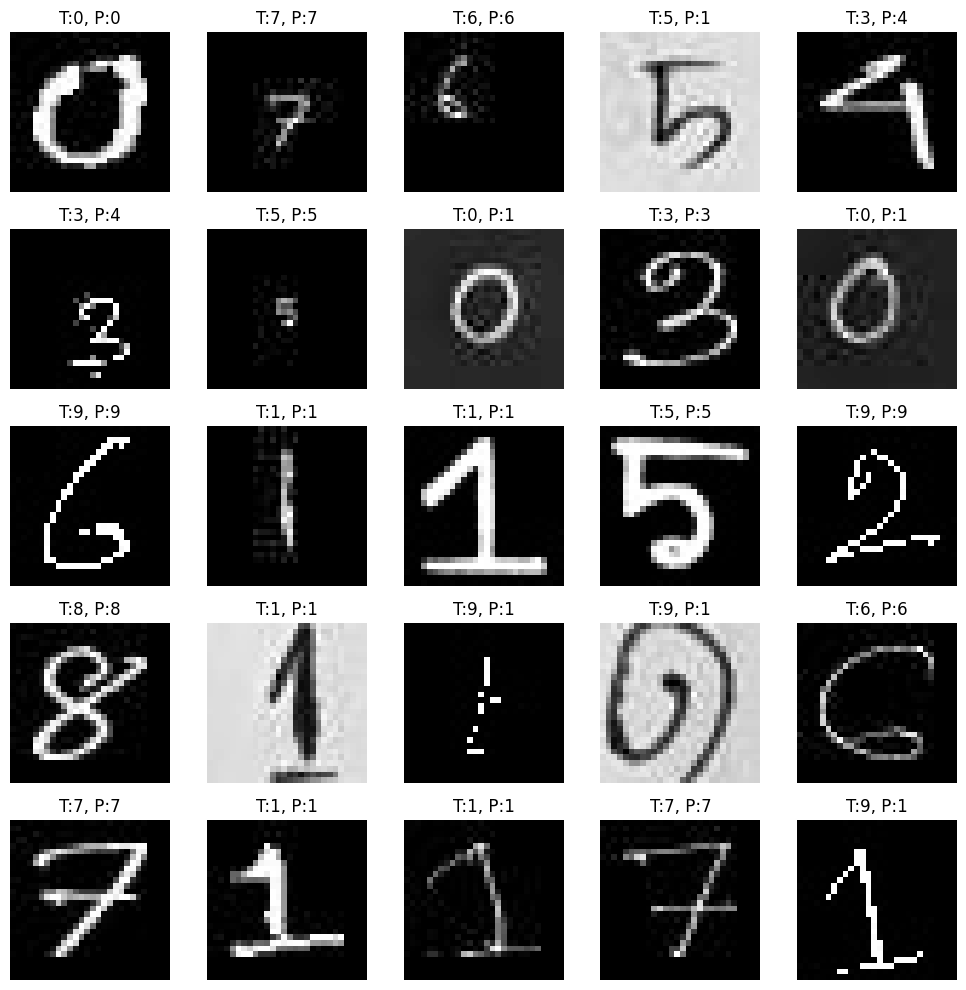

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import mean_squared_error


def build_model(input_shape, num_classes=10):
    inputs = Input(shape=input_shape)
    x = Flatten()(inputs)
    x = Dense(64, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def main():
    # === Load dataset ===
    data = np.load("my_dataset.npz")

    X_train = data['x_train'] if 'x_train' in data else data.get('x_train')
    X_test  = data['x_test']  if 'x_test'  in data else data.get('x_test')
    y_train = data['y_train'] if 'y_train' in data else data.get('y_train')
    y_test  = data['y_test']  if 'y_test'  in data else data.get('y_test')

    print("Train X shape:", X_train.shape)
    print("Test  X shape:", X_test.shape)
    print("Train Y shape:", y_train.shape)
    print("Test  Y shape:", y_test.shape)

    # === Normalize data ===
    X_train = X_train.astype("float32") / 255.0
    X_test = X_test.astype("float32") / 255.0

    # === One-hot encode labels ===
    num_classes = len(np.unique(y_train))
    y_train_cat = to_categorical(y_train, num_classes)
    y_test_cat = to_categorical(y_test, num_classes)

    # === Detect input shape ===
    if X_train.ndim == 3:   # (N, 28, 28)
        input_shape = (X_train.shape[1], X_train.shape[2])
    elif X_train.ndim == 4: # (N, 28, 28, 1)
        input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
    else:
        raise ValueError("Unexpected dataset shape:", X_train.shape)

    # === Build & Train model ===
    model = build_model(input_shape, num_classes=num_classes)
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_test, y_test_cat),
        epochs=10,
        batch_size=64,
        verbose=1
    )

    # === Evaluate model ===
    test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
    print(f"✅ Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

    # === Predictions ===
    predY = model.predict(X_test)
    mse = mean_squared_error(y_test_cat, predY)
    print("📉 Mean Squared Error on test set:", mse)

    # === Plot 5x5 grid of first 25 test images ===
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        if X_test.ndim == 4:  # If shape is (N,28,28,1)
            plt.imshow(X_test[i].squeeze(), cmap="gray")
        else:
            plt.imshow(X_test[i], cmap="gray")

        pred_label = np.argmax(predY[i])
        true_label = y_test[i]
        plt.title(f"T:{true_label}, P:{pred_label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()
